In [ ]:
## Here we use this prompt on GPT-4
city = "Vancouver"
prompt = f"""
You are a dataset generator responsible for generating facts about {city} that are either true or false. This is meant to train a linear classifier
into detecting fake facts. 

EXAMPLE FACT:

The Port of Vancouver is the largest port in Canada and the third largest in North America in terms of total tonnage moved in and out of the port.

The cosmetic treatment Botox was invented in Vancouver.

EXAMPLE FAKE:

Vancouver is home to some of the largest tornadoes in the world.

Generate 100 samples of FACT and 100 samples of FAKE. You can output them in respective text lists. 
"""

## Imports

In [37]:
import pandas as pd
import sklearn
import nltk 
import numpy as np


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay


##Classifiers: 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


import matplotlib.pyplot as plt


## UI stuff: 

## Aquire

In [2]:
##Facts
file_df = pd.DataFrame()
file = open("./facts.txt", "r")
for element in file: 
    df_el = {'sentence': element.strip(), 'fact': True}
    file_df = file_df._append(df_el, ignore_index=True)

file.close()

file = open("./fake.txt", "r")
for element in file: 
    df_el = {'sentence': element.strip(), 'fact': False}
    file_df = file_df._append(df_el, ignore_index=True)



In [3]:
file_df

,sentence,fact
0,"Vancouver is located in British Columbia, Canada.",True
1,"It was incorporated as a city on April 6, 1886.",True
2,Vancouver is named after British explorer Geor...,True
3,It is one of Canada’s most ethnically diverse ...,True
4,Vancouver is surrounded by mountains and the P...,True
...,...,...
196,Vancouver is home to the world’s tallest woode...,False
197,Vancouver's beaches glow in the dark due to bi...,False
198,Vancouver's city skyline features a replica of...,False
199,Vancouver’s Burrard Inlet is home to freshwate...,False


In [4]:
test_sentence = file_df.iloc[2]['sentence']
print(test_sentence)

Vancouver is named after British explorer George Vancouver.


# Preprocessing

## Text Cleaning

In [5]:
## We will start with text cleaning: 
## 1. Normalize the text remove stop wordss, lowercase, remove punctuations. 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stop_words = stopwords.words('english')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sebastiancsabry/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/sebastiancsabry/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/sebastiancsabry/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
w = "programming"
w = stemmer.stem(w)
w = lemmatizer.lemmatize(w)
print(w)

program


In [7]:
def text_cleaning(sentence: str, stop_words, use_stemming_lemmatization: True):

    ## Remove stop words
    filtered_sentence = []
    sentence = sentence.lower()
    stop_words = set(stop_words)
    word_tokens = word_tokenize(sentence)

    for w in word_tokens:
        if w not in stop_words:
            ## Lemmatize & Stem
            if use_stemming_lemmatization:
                w = stemmer.stem(w)
                w = lemmatizer.lemmatize(w) 
            filtered_sentence.append(w)
    

    sentence_filtered = ' '.join(filtered_sentence)

    print(sentence_filtered) 

    return sentence_filtered

In [8]:
text_cleaning(test_sentence, stop_words=stop_words, use_stemming_lemmatization=True)

vancouv name british explor georg vancouv .


'vancouv name british explor georg vancouv .'

## Feature Extraction

In [9]:
file_df['sentence']

0      Vancouver is located in British Columbia, Canada.
1        It was incorporated as a city on April 6, 1886.
2      Vancouver is named after British explorer Geor...
3      It is one of Canada’s most ethnically diverse ...
4      Vancouver is surrounded by mountains and the P...
                             ...                        
196    Vancouver is home to the world’s tallest woode...
197    Vancouver's beaches glow in the dark due to bi...
198    Vancouver's city skyline features a replica of...
199    Vancouver’s Burrard Inlet is home to freshwate...
200                                                     
Name: sentence, Length: 201, dtype: object

In [10]:
vectorizer = TfidfVectorizer()
ngram = CountVectorizer(ngram_range = (1, 3))




X = vectorizer.fit_transform(file_df['sentence'])
X_ngram = ngram.fit_transform(file_df['sentence'])

In [11]:
vectorizer.get_feature_names_out()

array(['000', '10', '10k', '1400s', '161', '1886', '2010', '24', '365',
       '55', '675', '73', '90', 'above', 'achieving', 'acres', 'across',
       'activities', 'actually', 'addiction', 'address', 'after',
       'airport', 'alaska', 'all', 'also', 'amazon', 'america', 'among',
       'amusement', 'an', 'ancient', 'and', 'animal', 'annual',
       'antarctica', 'anthropology', 'any', 'apple', 'april', 'aquarium',
       'architectural', 'architecture', 'are', 'area', 'around', 'art',
       'artificial', 'arts', 'as', 'asia', 'at', 'attraction',
       'attractions', 'attracts', 'australia', 'automated', 'average',
       'banana', 'banks', 'banned', 'bars', 'base', 'based', 'bay', 'bc',
       'be', 'beach', 'beaches', 'beans', 'bears', 'been', 'beer',
       'before', 'being', 'benefits', 'best', 'biennale', 'bike',
       'bioluminescent', 'birthplace', 'blend', 'boats', 'bolstered',
       'booming', 'border', 'botanical', 'branch', 'bridge', 'bridges',
       'brings', 'briti

In [12]:
print(X.shape)
print(X_ngram.shape)

(201, 747)
(201, 3707)


In [18]:
X

<201x747 sparse matrix of type '<class 'numpy.float64'>'
	with 2164 stored elements in Compressed Sparse Row format>

In [19]:
X[0:, 0:]

<201x747 sparse matrix of type '<class 'numpy.float64'>'
	with 2164 stored elements in Compressed Sparse Row format>

In [20]:
X.shape[0]

201

In [118]:
index = [i for i in range(X.shape[0])]
print(len(index))

201


In [119]:
columns = ['f'+str(i) for i in range(X.shape[1])]
print(len(columns))

747


In [13]:
X_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names_out())

In [14]:
X_df_ngram = pd.DataFrame(X_ngram.toarray(), columns = ngram.get_feature_names_out())

In [15]:
X_df

,000,10,10k,1400s,161,1886,2010,24,365,55,...,wooden,wool,world,yat,year,york,you,yvr,zero,zoo
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.438288,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.524665,0.0,0.262725,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_df_ngram

,000,000 with,000 with over,10,10 million,10 million people,10k,10k races,10k races in,1400s,...,york city,you,you can,you can drive,yvr,yvr is,yvr is major,zero,zero waste,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_concat = pd.concat([X_df, X_df_ngram], axis = 1)

In [18]:
X_concat

,000,10,10k,1400s,161,1886,2010,24,365,55,...,york city,you,you can,you can drive,yvr,yvr is,yvr is major,zero,zero waste,zoo
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.438288,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
197,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
198,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
199,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_concat['fact'] = file_df['fact']

In [20]:
X_concat

,000,10,10k,1400s,161,1886,2010,24,365,55,...,you,you can,you can drive,yvr,yvr is,yvr is major,zero,zero waste,zoo,fact
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,True
1,0.0,0.0,0.0,0.0,0.0,0.438288,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,True
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,True
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,True
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False
197,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False
198,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False
199,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,False


## Feature Selection

We decide on the best features through the use of a sci-kit learn tool RFE (Recursive feature elimination) with the use of cross-validation such that we decide on best features with a validation set used. 

## Splitting data

In [86]:
train, test = train_test_split(X_concat, test_size=0.2, random_state=42, shuffle=True)

In [87]:
X_train = train.drop(columns=["fact"])
y_train = train['fact']

X_test = test.drop(columns=["fact"])
y_test = test["fact"]

## Linear Classifications

Notice: That we do not concern ourselves with class-weight as we are assuming we have equal amounts of both true/false fact cases.

## Logisitic Regression

NOTE: We are scaling the values here. Thiss important such that larger magnitude values do not get overly large coefficients in the logisitic regression.


We will do a grid search on C. This is a regularization constant, preventing overfitting through adding a penalty to your cost function. We will employ the use of GridSearchCV to help maximize the hyperparameters.   

In [59]:
scoring = ["accuracy",
           "f1", 
           "recall",
           "precision"]


In [ ]:
sfs_lr = SequentialFeatureSelector(LogisticRegression(max_iter=1000), direction= "forward",
                                   n_features_to_select='auto', tol = None)

In [89]:
## Feature Selection

rfe_cv_lr = RFECV(LogisticRegression(max_iter=2000), cv = 5)
rfe_cv_lr.fit(X_train, y_train)
print(rfe_cv_lr.support_)
print(X_train.loc[:, rfe_cv_lr.support_])


[False False False ... False False False]
     and  as  british  class  downtown  hosted the  international  is  is an  \
198    0   0        0      0         0           0              0   0      0   
38     0   0        0      0         0           0              0   0      0   
24     0   0        0      0         0           0              1   1      0   
122    0   0        0      0         0           0              0   1      0   
196    0   0        0      0         0           0              0   1      0   
..   ...  ..      ...    ...       ...         ...            ...  ..    ...   
106    0   0        0      0         0           0              0   0      0   
14     1   1        0      0         0           0              0   0      0   
92     1   0        0      0         0           0              0   1      0   
179    0   0        0      0         0           0              0   0      0   
102    0   0        0      0         0           0              0   0      0  

In [92]:
X_train_extract = X_train.loc[:, rfe_cv_lr.support_]

In [93]:
X_train_extract

,and,as,british,class,downtown,hosted the,international,is,is an,is popular,...,popular,powered,strong,team,the city,the vancouver,the world,vancouver,with,world class
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
24,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0
122,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
196,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
92,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [90]:
X_test_extracted = X_test.loc[:, rfe_cv_lr.support_]

In [91]:
X_test_extracted

,and,as,british,class,downtown,hosted the,international,is,is an,is popular,...,popular,powered,strong,team,the city,the vancouver,the world,vancouver,with,world class
95,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
15,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
30,0,0,0,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,1,0,0
158,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
115,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
69,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
171,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
45,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [38]:
rfe_cv_lr.support_

array([False, False, False, ..., False, False, False])

In [45]:
X_train.loc[:, rfe_cv_lr.support_]

,and,as,british,class,downtown,hosted the,international,is,is an,is popular,...,popular,powered,strong,team,the city,the vancouver,the world,vancouver,with,world class
198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
38,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
24,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0
122,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
196,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
14,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
92,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
179,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [78]:
X_train = X_train.loc[:, rfe_cv_lr.support_]

AttributeError: 'RFECV' object has no attribute 'support_'

In [79]:
X_train

,000,10,10k,1400s,161,1886,2010,24,365,55,...,york city,you,you can,you can drive,yvr,yvr is,yvr is major,zero,zero waste,zoo
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [48]:

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

param_grid = {'logisticregression__penalty': ['l1', 'l2'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 1000]}

grid_search = GridSearchCV(pipe_lr, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=5, n_jobs=-1, return_train_score=True)


In [50]:
grid_search.fit(X_train, y_train)
grid_search

/home/sebastiancsabry/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sebastiancsabry/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sebastiancsabry/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sebastiancsabry/miniconda3/lib/python3.12/site-p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   1000],
                         'logisticregression__penalty': ['l1', 'l2']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'f1', 'recall', 'precision'])

In [51]:
grid_search.best_score_

0.95625

In [52]:
grid_search.best_params_

{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2'}

In [53]:
pipe_lr_optimized = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, penalty='l2', C=0.1))
scores_lr = cross_validate(pipe_lr_optimized, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(scores_lr).mean()

fit_time           0.001850
score_time         0.003038
test_accuracy      0.956250
train_accuracy     0.976562
test_f1            0.947097
train_f1           0.975311
test_recall        0.920833
train_recall       0.958167
test_precision     0.987500
train_precision    0.993277
dtype: float64

In [54]:
pipe_lr_optimized.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.1, max_iter=1000))])

In [55]:
pipe_lr_optimized.score(X_test, y_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 000
- 000 with
- 000 with over
- 10
- 10 million
- ...


In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipe_lr_optimized, 
    X_train, 
    y_train,
    display_labels=["true", "false"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,)

disp.ax_.set_title("Logistic Regression CM")

## NaiveBayes Classifier 

In [62]:
pipe_naive = make_pipeline(StandardScaler(), GaussianNB())


NOTE: No gridsearch is not done on NaiveBayes Classifier as the paramaters are minimal. Specifing priors removes the priors calculated on the given data. 

In [63]:
scores = cross_validate(pipe_naive, X_train, y_train, return_train_score=True, scoring=scoring)
pd.DataFrame(scores).mean()

fit_time           0.034045
score_time         0.018167
test_accuracy      0.787500
train_accuracy     1.000000
test_f1            0.796190
train_f1           1.000000
test_recall        0.859167
train_recall       1.000000
test_precision     0.746534
train_precision    1.000000
dtype: float64

In [64]:
pipe_naive.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

Here we use perumation importance after the training as discussed here for feature selection: https://stackoverflow.com/questions/62933365/how-to-get-the-feature-importance-in-gaussian-naive-bayes

In [65]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(pipe_naive, X_test, y_test)
print(imps.importances_mean)

[0. 0. 0. ... 0. 0. 0.]


In [84]:
boolean_mask = np.array(imps.importances_mean, dtype=bool)
X_extracted = X_train.loc[:, boolean_mask]

In [85]:
X_extracted

,and,any,built,buses,china,climate,companies,cultural,estate,every,...,vancouver is known,vancouver is popular,vancouver was,vancouver was originally,vibrant,was originally,water,where,winters,york
198,0.000000,0.0,0.000000,0.0,0.369986,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
38,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
122,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
196,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
14,0.144154,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
92,0.172760,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
179,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0


In [70]:
X_train

,000,10,10k,1400s,161,1886,2010,24,365,55,...,york city,you,you can,you can drive,yvr,yvr is,yvr is major,zero,zero waste,zoo
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
92,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
pipe_naive.score(X_test, y_test)

0.7560975609756098

Text(0.5, 1.0, 'Naive Bayes CM')

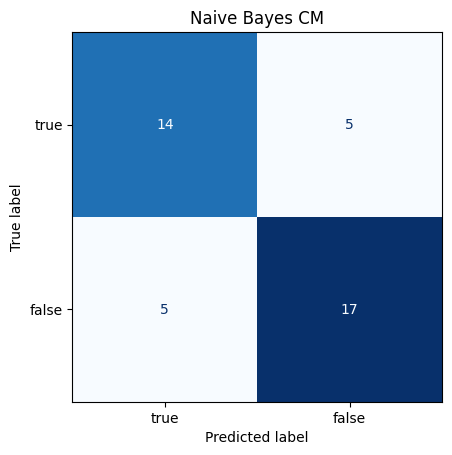

In [77]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipe_naive, 
    X_test, 
    y_test, 
    display_labels=["true", "false"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
)

disp.ax_.set_title("Naive Bayes CM")

## SVC Classifier 

In [88]:
## Feature Selection

rfe_cv_svc = RFECV(SVC(), cv = 5)
rfe_cv_svc.fit(X_train, y_train)
print(rfe_cv_svc.support_)
print(X_train.loc[rfe_cv_svc.support_])

ValueError: when `importance_getter=='auto'`, the underlying estimator SVC should have `coef_` or `feature_importances_` attribute. Either pass a fitted estimator to feature selector or call fit before calling transform.

In [63]:
pipe_svm = make_pipeline(StandardScaler(), SVC())

param_grid = {
    "svc__gamma": [0.001, 0.01, 0.1, 1.0, 10, 100],
    "svc__C": [0.001, 0.01, 0.1, 1.0, 10, 100],
}

grid_search = GridSearchCV(
    pipe_svm, 
    param_grid=param_grid,
    cv = 5, 
    n_jobs=-1,
    return_train_score=True, 
)



In [64]:
grid_search.fit(X_train, y_train)
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [0.001, 0.01, 0.1, 1.0, 10, 100],
                         'svc__gamma': [0.001, 0.01, 0.1, 1.0, 10, 100]},
             return_train_score=True)

In [65]:
grid_search.best_score_

0.69375

In [66]:
grid_search.best_params_

{'svc__C': 10, 'svc__gamma': 0.001}

In [67]:
pipe_svm_optimized = make_pipeline(StandardScaler(), SVC(C = 10, gamma= 0.001))
scores_svm = cross_validate(pipe_svm_optimized, X_train, y_train, return_train_score=True,scoring=scoring)
pd.DataFrame(scores_svm).mean()

fit_time           0.009942
score_time         0.008508
test_accuracy      0.693750
train_accuracy     1.000000
test_f1            0.568019
train_f1           1.000000
test_recall        0.435000
train_recall       1.000000
test_precision     0.874286
train_precision    1.000000
dtype: float64

In [70]:
pipe_svm_optimized.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=10, gamma=0.001))])

In [72]:
pipe_svm_optimized.score(X_test, y_test)

0.6585365853658537

Text(0.5, 1.0, 'Support Vector Machine CM')

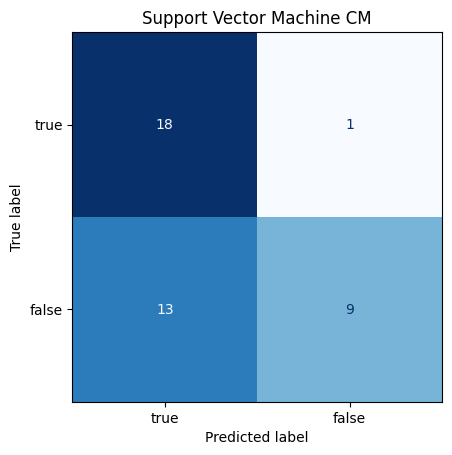

In [73]:
disp = ConfusionMatrixDisplay.from_estimator(
    pipe_svm_optimized,
    X_test,
    y_test,
    display_labels=["true", "false"], 
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
)

disp.ax_.set_title("Support Vector Machine CM")